# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [3]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline
from helper import *

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

1.Data Cleaning
Portfolio Dataframe Tasks:

Split the channels into several columns.
Split offer_type into several columns.
change id column name to offer_id.

In [4]:

portfolio_clean = clean_portfolio(portfolio)

#### Profile Dataframe Tasks:

Fix the date
Change the column name id to customer_id.
change id column name to offer_id.
There are 2,175 missing values in the gender and income columns

In [7]:
profile_clean = clean_profile(profile)


#### Profile Dataframe Tasks:

Split value in several columns for offers and transactions

Split event column into sevelar columns

Change column name person to customer_id

In [9]:
transcript_clean = clean_transcript(transcript)

Let's merge all the dataframes into one for analysis. This dataframe will have several NaN values in places where that piece of data is not needed. For instance, in the event of an offer reception, the transaction value will be NaN. We'll ignore those in our analysis

In [10]:
df = merge_datasets(portfolio_clean, profile_clean, transcript_clean)

In [11]:

df.head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,gender,age,...,gender_M,gender_O,reward,difficulty,duration,offer_type,channel_email,channel_mobile,channel_social,channel_web
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,B3,NaN,F,75,...,0,0,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,D1,NaN,None,118,...,0,0,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,D4,NaN,M,68,...,1,0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,D3,NaN,None,118,...,0,0,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,B2,NaN,None,118,...,0,0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0


## Analysis
#### Population Analysis
Let's check the total amount that the experiment ran

In [14]:
df.time.max() / 24

29.75

In [15]:
df.shape

(306534, 24)

The experiment was run for almost 30 days, and a grand total of 306,534 events were collected.

c:\Capstone_project\Starbucks_Capstone_Nanodegree_Project\starbucks\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


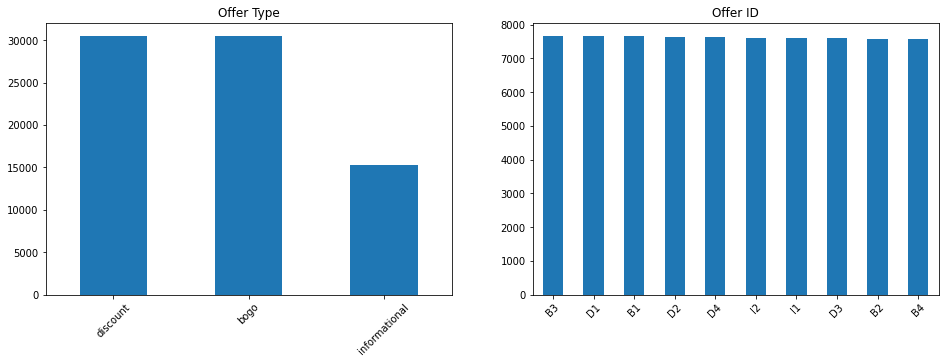

In [16]:
plt.subplot(121)
df[df.event_offer_received == 1].offer_type.value_counts().plot(kind='bar', rot=45, figsize=(16,5))
plt.title('Offer Type');

plt.subplot(122)
df[df.event_offer_received == 1].offer_id.value_counts().plot(kind='bar', rot=45)
plt.title('Offer ID');

In [17]:
df[df.event_offer_received == 1].offer_id.value_counts()

B3    7677
D1    7668
B1    7658
D2    7646
D4    7632
I2    7618
I1    7617
D3    7597
B2    7593
B4    7571
Name: offer_id, dtype: int64

Each offer was received almost the same number of times. The data simulator probably used a uniform distribution for distributing the offers.

## Customers Dataframe
This dataframe is intended to aggregate offer and transactional data on a per customer basis. This should facilitate the analysis of each customer's transactional behavior

In [18]:
customers = per_customer_data(df, profile_clean)

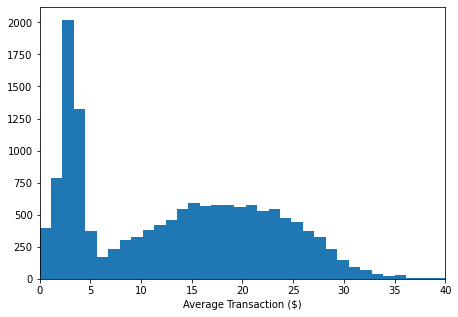

In [19]:
plt.figure(figsize=(16,5))

bins = 400

avg_transaction = customers[customers.valid == 1].total_expense / customers[customers.valid == 1].total_transactions
avg_transaction.fillna(0, inplace=True)
plt.subplot(121)
plt.hist(avg_transaction, bins)
plt.xlabel('Average Transaction ($)')
ax = plt.gca();
ax.set_xlim(0,40);

The average transaction value seems to follow a bi-modal distribution, while the total expense an exponential distribution with negative parameter.

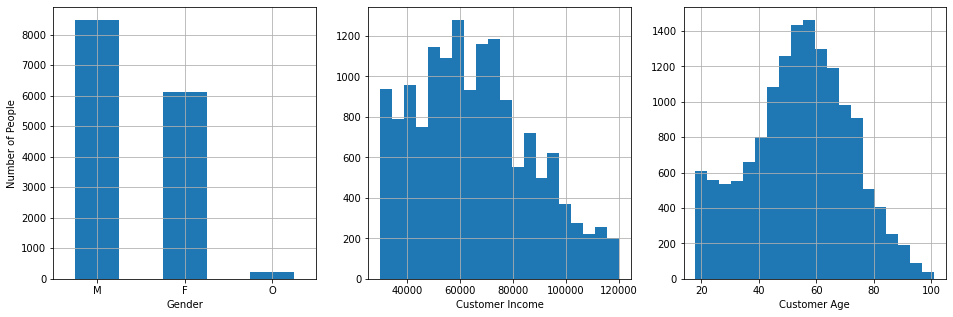

In [20]:
plt.figure(figsize=(16,5))

plt.subplot(131)
customers.gender.value_counts().reindex(['M', 'F', 'O']).plot(kind='bar', rot=0, figsize=(16,5), color='tab:blue');
plt.ylabel('Number of People');
plt.xlabel('Gender');
plt.grid();

plt.subplot(132)
cust_income = customers[customers.income_group > 0].income#_group.value_counts().reindex(range(30000, 111000,10000))
plt.xlabel('Customer Income');
plt.hist(cust_income, 20)
plt.grid()

plt.subplot(133)
cust_age = customers[customers.valid == 1].age
plt.xlabel('Customer Age');
plt.hist(cust_age, 20)
plt.grid(True)

Population distributions by gender, income and age. The sample provides significantly more males. Both the income and the age distribution seem to approach a normal distribution

c:\Capstone_project\Starbucks_Capstone_Nanodegree_Project\starbucks\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


Text(0, 0.5, '$')

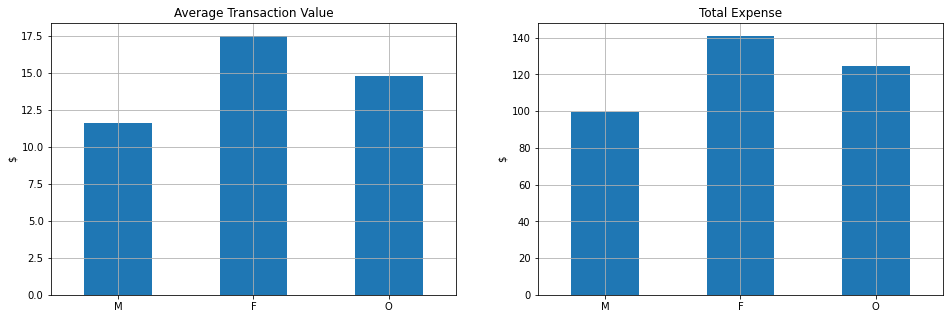

In [21]:
plt.figure(figsize=(16,5))

plt.subplot(121)
gender_groupby = customers[customers.valid == 1].groupby('gender')
gender_transacts = gender_groupby.total_transactions.sum()
gender_expense = gender_groupby.total_expense.sum()
(gender_expense / gender_transacts).reindex(['M', 'F', 'O']).plot(kind='bar', rot=0, color='tab:blue');
plt.title('Average Transaction Value');
plt.xlabel('');
plt.grid();
plt.ylabel('$')

plt.subplot(122)
gender_groupby.total_expense.mean().reindex(['M', 'F', 'O']).plot(kind='bar', rot=0, color='tab:blue');
plt.title('Total Expense');
plt.xlabel('');
plt.grid();
plt.ylabel('$')

By gender, women make more expensive tranasactions and spend more money in general. Men spent the least in both metrics.

c:\Capstone_project\Starbucks_Capstone_Nanodegree_Project\starbucks\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


(0.0, 200.0)

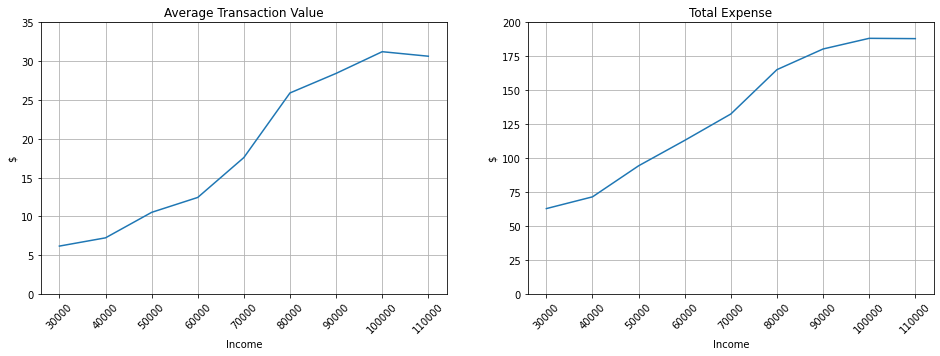

In [22]:
plt.figure(figsize=(16,5))

plt.subplot(121)
income_groupby = customers[(customers.valid == 1) & (customers.income_group > 0)].groupby('income_group')
income_transacts = income_groupby.total_transactions.sum()
income_expense = income_groupby.total_expense.sum()
ax = (income_expense / income_transacts).reindex(range(30000, 111000,10000)).plot(kind='line', rot=45, color='tab:blue');
plt.title('Average Transaction Value');
plt.xlabel('Income')
plt.ylabel('$')
plt.grid()
ax.set_ylim(0, 35)

plt.subplot(122)
ax = income_groupby.total_expense.mean().reindex(range(30000, 111000,10000)).plot(kind='line', rot=45, color='tab:blue');
plt.title('Total Expense');
plt.xlabel('Income')
plt.ylabel('$')
plt.grid()
ax.set_ylim(0, 200)


Expenses and average transaction value grow as the income grows, which is expected.

c:\Capstone_project\Starbucks_Capstone_Nanodegree_Project\starbucks\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


(0.0, 140.0)

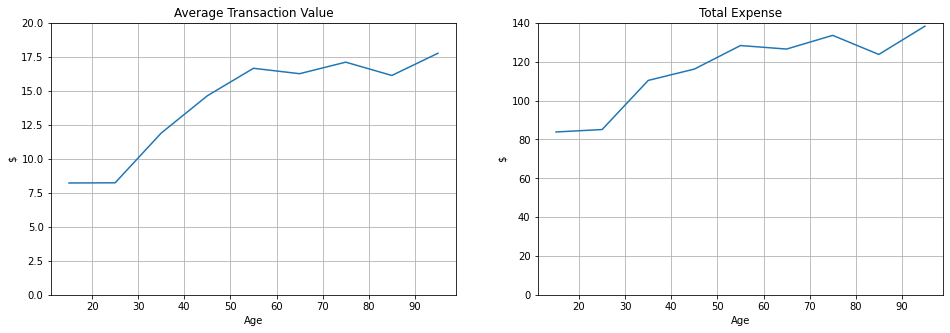

In [23]:
plt.figure(figsize=(16,5))


plt.subplot(121)
age_groupby = customers[(customers.valid == 1) & (customers.income_group > 0)].groupby('age_group')
age_transacts = age_groupby.total_transactions.sum()
age_expense = age_groupby.total_expense.sum()
ax = (age_expense / age_transacts).reindex(range(15, 96,10)).plot(kind='line', rot=0, color='tab:blue');
plt.title('Average Transaction Value');
ax.set_ylim(0, 20)
plt.grid(True)
plt.xlabel('Age')
plt.ylabel('$')


plt.subplot(122)
ax = age_groupby.total_expense.mean().reindex(range(15, 96,10)).plot(kind='line', rot=0, color='tab:blue');
plt.title('Total Expense');
plt.grid(True);
plt.xlabel('')
plt.xlabel('Age')
plt.ylabel('$')
ax.set_ylim(0, 140)

Similarly to income, as people get older, the value of their transactions and the total expense increases. This might be to the fact that there is a direct correlation between age and income.

## Offer Analysis

### Analysis per offer kind

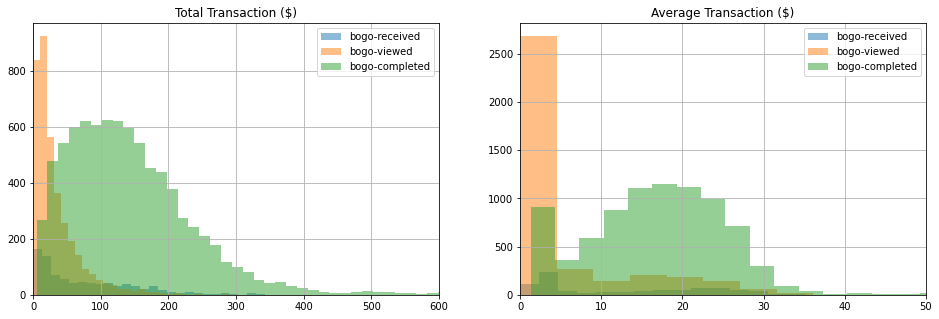

In [25]:

plot_offer_expense(customers, 'bogo')

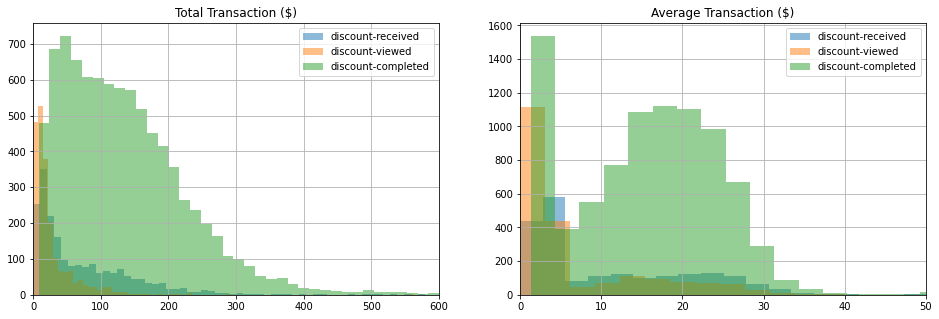

In [26]:
plot_offer_expense(customers, 'discount')

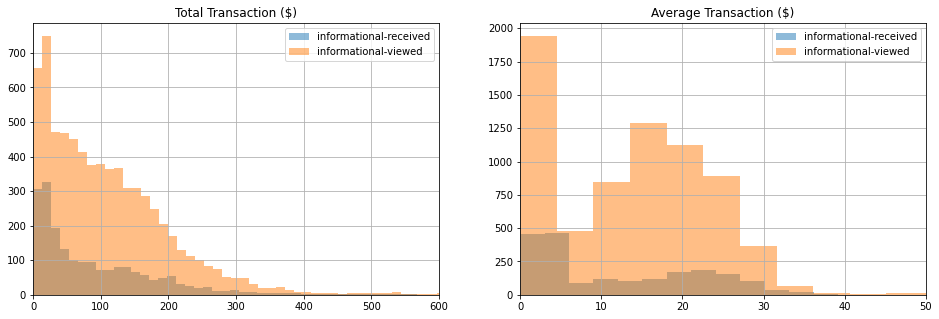

In [27]:
plot_offer_expense(customers, 'informational')

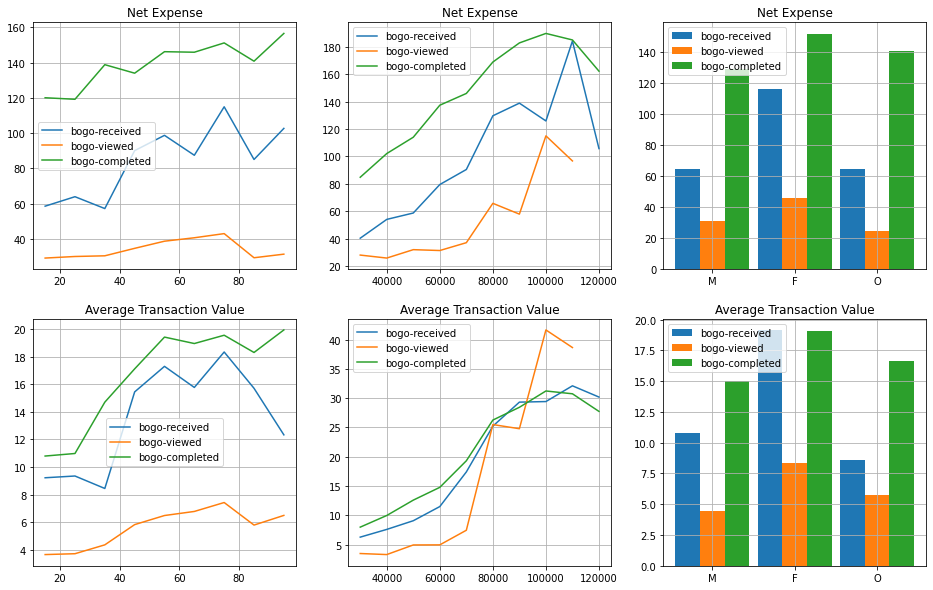

In [28]:
plot_offer_expense_by(customers, 'bogo')

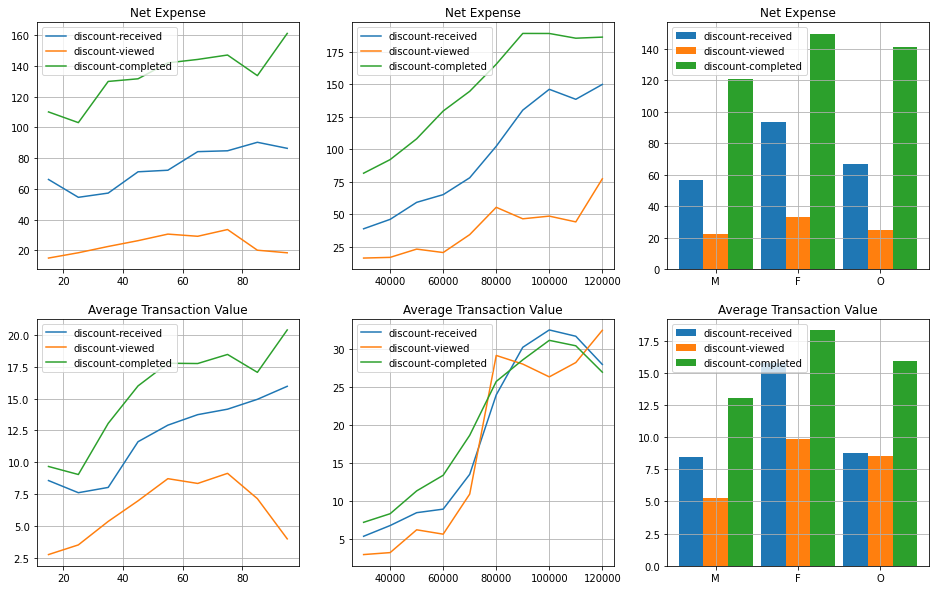

In [29]:
plot_offer_expense_by(customers, 'discount')

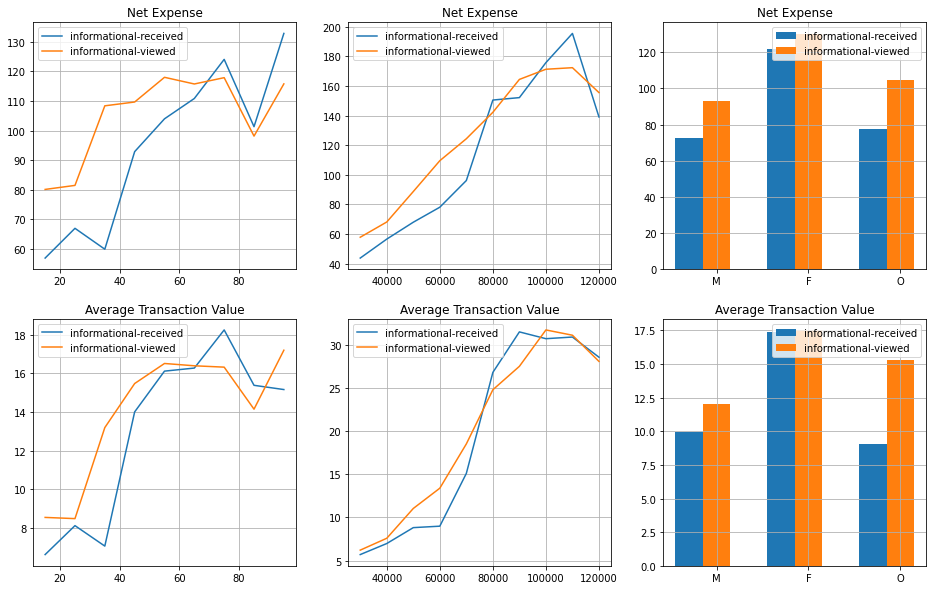

In [30]:
plot_offer_expense_by(customers, 'informational')

The spending patterns are similar for customers that received, viewed and completed offers. It's important to note that for informational offers, they seem to be more relevant for younger customers. Similarly, customers that make less than $80,000 don't seem to be impacted by this kind of offers.

## Offer Recommendation
### Simple recommendation system
Knowledge based recommendations for the users without demographics data.

Get the most popular offers to the users without demographics data.

Based on data for customers with:

    possitive net_expense
    at least 5 transactions completed
    only count offers that were both viewed and completed

In [33]:
offers = get_most_popular_offers(customers, n_top=10)
print(offers[0])
print(offers[1])

['B2', 'B1', 'D1', 'D4', 'B3', 'B4', 'D3', 'D2', 'I1', 'I2']
{'B2': 144.72500000000002, 'B1': 144.505, 'D1': 144.40000000000003, 'D4': 133.92000000000002, 'B3': 127.47999999999999, 'B4': 126.145, 'D3': 125.105, 'D2': 117.8, 'I1': 109.76999999999998, 'I2': 88.41}


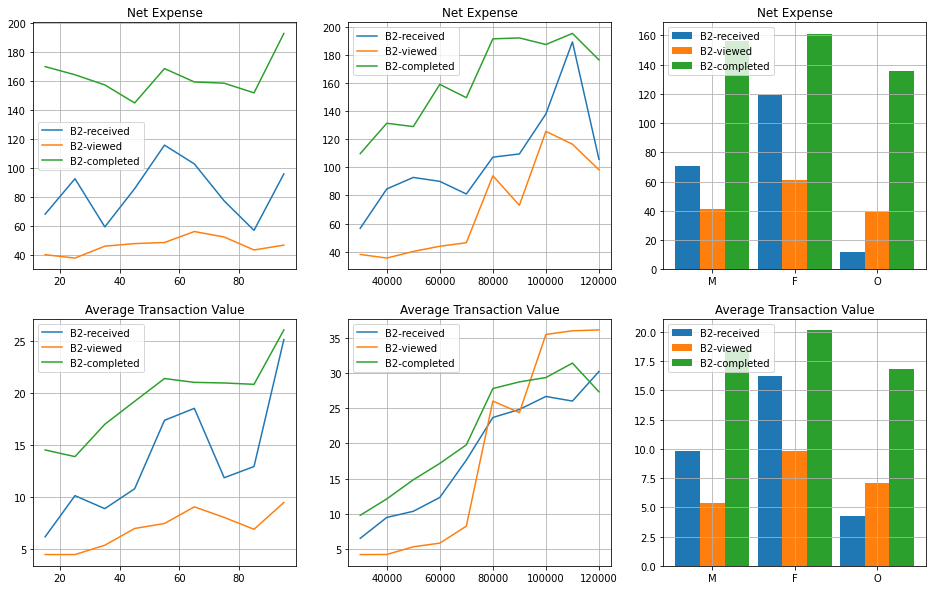

In [34]:
plot_offer_expense_by(customers, 'B2')

This recommendation system doesn't take into account any demographics data. We see that in the selected offer (B2) for people that make more than $90,000 the average transaction value is lower for completed than viewed offers. This offer might not be the best for that population.

### Recommendation system with filters
Knowledge based recommendations for the users using demographics data as filters.

Based on data for customers with:

    positive net_expense
    at least 5 transactions completed
    only count offers that were both viewed and completed

In [35]:
offers = get_most_popular_offers_filtered(customers, n_top=10, income=95000)
print(offers[0])
print(offers[1])

['B3', 'D3', 'D1', 'D4', 'B1', 'D2', 'B4', 'B2', 'I1', 'I2']
{'B3': 204.325, 'D3': 204.22000000000003, 'D1': 204.21, 'D4': 197.41000000000003, 'B1': 196.62, 'D2': 195.17, 'B4': 187.98, 'B2': 186.17000000000002, 'I1': 185.275, 'I2': 180.41500000000002}


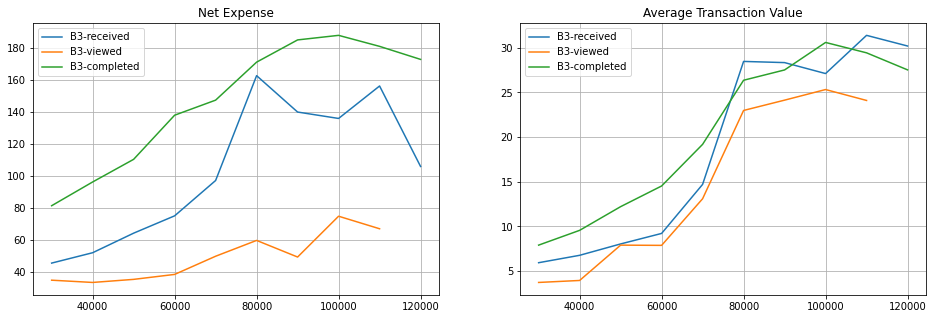

In [37]:
offer = 'B3'
rcv_by, vwd_by, cpd_by = get_offer_stat_by(customers, 'net_expense', offer, 'income_group', aggr='mean')
rcv_avg_by, vwd_avg_by, cpd_avg_by = get_average_expense_by(customers, offer, 'income_group')

plt.figure(figsize=(16,5))

plt.subplot(121)
plt.plot(rcv_by, label='{}-received'.format(offer))
plt.plot(vwd_by, label='{}-viewed'.format(offer))
plt.plot(cpd_by,  label='{}-completed'.format(offer))
plt.legend(loc='best')
plt.title('Net Expense');
plt.grid();


plt.subplot(122)
plt.plot(rcv_avg_by, label='{}-received'.format(offer))
plt.plot(vwd_avg_by, label='{}-viewed'.format(offer))
plt.plot(cpd_avg_by, label='{}-completed'.format(offer))
plt.legend(loc='best')
plt.title('Average Transaction Value');
plt.grid();

Here we see that for this demographic, the completed offers data for the recommended offer (B3) provides both the maximum net expense and average transaction value

### What about for gender?

In [40]:
offers = get_most_popular_offers_filtered(customers, n_top=10, gender='M')
print(offers[0])
print(offers[1])

['B2', 'D1', 'B1', 'D4', 'B3', 'B4', 'D3', 'I1', 'D2', 'I2']
{'B2': 138.835, 'D1': 136.89000000000001, 'B1': 136.45, 'D4': 126.485, 'B3': 119.77000000000001, 'B4': 115.60999999999999, 'D3': 110.4, 'I1': 109.575, 'D2': 101.88, 'I2': 71.00500000000001}


The recommendation system provides the same as the systems without filters. Maybe due to the fact that most of the population are men.

In [41]:
offers = get_most_popular_offers_filtered(customers, n_top=10, gender='F')
print(offers[0])
print(offers[1])

['D1', 'D4', 'B1', 'D3', 'B2', 'B4', 'D2', 'I1', 'B3', 'I2']
{'D1': 154.83, 'D4': 154.62, 'B1': 153.745, 'D3': 153.59000000000003, 'B2': 150.37, 'B4': 145.21999999999997, 'D2': 145.03000000000003, 'I1': 142.23, 'B3': 141.60999999999999, 'I2': 132.5}


([<matplotlib.axis.XTick at 0x13b779a0b50>,
 [Text(0.3, 0, 'M'), Text(1.3, 0, 'F'), Text(2.3, 0, 'O')])

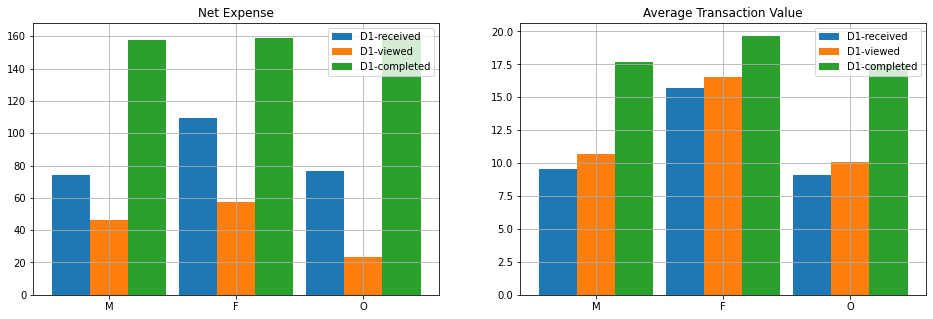

In [42]:
rcv_gender, vwd_gender, cpd_gender = get_offer_stat_by(customers, 'net_expense', 'D1', 'gender', aggr='mean')
rcv_avg_gender, vwd_avg_gender, cpd_avg_gender = get_average_expense_by(customers, 'D1', 'gender')

plt.figure(figsize=(16,5))

plt.subplot(121)
index = np.array([0,1,2])
bar_width = 0.3

plt.bar(index, rcv_gender.reindex(['M', 'F', 'O']), bar_width, label='D1-received')
plt.bar(index + bar_width, vwd_gender.reindex(['M', 'F', 'O']), bar_width, label='D1-viewed')
plt.bar(index + 2*bar_width, cpd_gender.reindex(['M', 'F', 'O']), bar_width, label='D1-completed')
plt.grid();
plt.legend(loc='best');
plt.title('Net Expense');
plt.xticks(index + bar_width, ('M', 'F', 'O'));

plt.subplot(122)

index = np.array([0,1,2])
bar_width = 0.3
plt.bar(index, rcv_avg_gender.reindex(['M', 'F', 'O']), bar_width, label='D1-received')
plt.bar(index + bar_width, vwd_avg_gender.reindex(['M', 'F', 'O']), bar_width, label='D1-viewed')
plt.bar(index + 2*bar_width, cpd_avg_gender.reindex(['M', 'F', 'O']), bar_width, label='D1-completed')
plt.grid();
plt.legend(loc='best');
plt.title('Average Transaction Value');
plt.xticks(index + bar_width, ('M', 'F', 'O'));


We noticed that for women the first recommendation is D1. This shows that women don't care too much of the higher rewards like BOGO offers but the coffee itself.

In [43]:
offers = get_most_popular_offers_filtered(customers, n_top=10, gender='O')
print(offers[0])
print(offers[1])

['B3', 'D4', 'B1', 'D3', 'D1', 'D2', 'B2', 'I1', 'B4', 'I2']
{'B3': 162.78000000000003, 'D4': 162.78000000000003, 'B1': 160.93, 'D3': 160.42000000000002, 'D1': 143.25, 'D2': 142.73999999999998, 'B2': 138.84, 'I1': 129.65499999999997, 'B4': 122.44, 'I2': 88.63000000000001}


([<matplotlib.axis.XTick at 0x13b77bc9a00>,
 [Text(0.3, 0, 'M'), Text(1.3, 0, 'F'), Text(2.3, 0, 'O')])

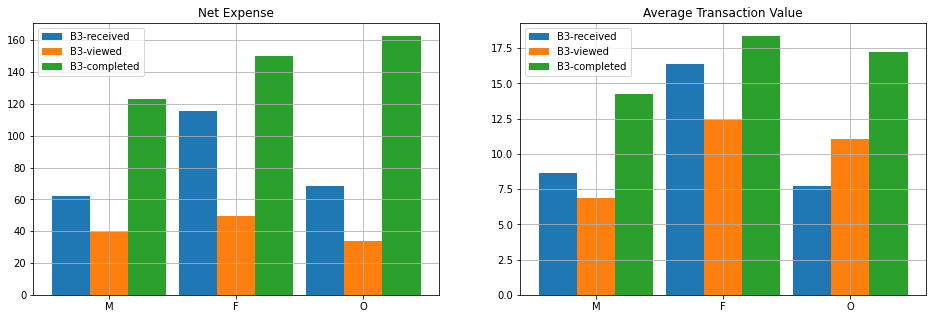

In [44]:
rcv_gender, vwd_gender, cpd_gender = get_offer_stat_by(customers, 'net_expense', 'B3', 'gender', aggr='mean')
rcv_avg_gender, vwd_avg_gender, cpd_avg_gender = get_average_expense_by(customers, 'B3', 'gender')

plt.figure(figsize=(16,5))

plt.subplot(121)
index = np.array([0,1,2])
bar_width = 0.3

plt.bar(index, rcv_gender.reindex(['M', 'F', 'O']), bar_width, label='B3-received')
plt.bar(index + bar_width, vwd_gender.reindex(['M', 'F', 'O']), bar_width, label='B3-viewed')
plt.bar(index + 2*bar_width, cpd_gender.reindex(['M', 'F', 'O']), bar_width, label='B3-completed')
plt.grid();
plt.legend(loc='best');
plt.title('Net Expense');
plt.xticks(index + bar_width, ('M', 'F', 'O'));

plt.subplot(122)

index = np.array([0,1,2])
bar_width = 0.3
plt.bar(index, rcv_avg_gender.reindex(['M', 'F', 'O']), bar_width, label='B3-received')
plt.bar(index + bar_width, vwd_avg_gender.reindex(['M', 'F', 'O']), bar_width, label='B3-viewed')
plt.bar(index + 2*bar_width, cpd_avg_gender.reindex(['M', 'F', 'O']), bar_width, label='B3-completed')
plt.grid();
plt.legend(loc='best');
plt.title('Average Transaction Value');
plt.xticks(index + bar_width, ('M', 'F', 'O'));


Finally, for other gender, the recommended offer is B3. This makes sense since for this offer, the net expense of the other gender is higher than the other genders. The average transaction value is also high, just a $1 less than the one for women.